In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

 

def preprocess(img):
    imgGray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    imgBlur = cv2.GaussianBlur(imgGray,(5,5),1)
    imgthreshold = cv2.adaptiveThreshold(imgBlur,255,1,1,11,2)
    return imgthreshold


def biggestContour(contours):
    biggest = np.array([])
    maxArea = 0
    for i in contours:
        area = cv2.contourArea(i)
        if(area>50):
            peri = cv2.arcLength(i,True)
            approx = cv2.approxPolyDP(i, 0.02*peri, True)
            if(area>maxArea and len(approx)==4):
                biggest = approx
                maxArea = area
    return biggest,maxArea


def reorder(myPoints):
    myPoints = myPoints.reshape((4,2))
    newmyPoints = np.zeros((4,1,2), dtype=np.int32)
    add = myPoints.sum(1)
    newmyPoints[0] = myPoints[np.argmin(add)]
    newmyPoints[3] = myPoints[np.argmax(add)]
    diff = np.diff(myPoints, axis=1)
    newmyPoints[1] = myPoints[np.argmin(diff)]
    newmyPoints[2] = myPoints[np.argmax(diff)]
    
    return newmyPoints

def splitBoxes(img):
    rows = np.vsplit(img,9)
    boxes = []
    for r in rows:
        cols = np.hsplit(r,9)
        for box in cols:
            boxes.append(box)
    return boxes

def intializemodel():
    model = load_model("MyModel.h5")
    return model

def getPrediction(boxes,model):
    result = []
    for i in boxes:
        img = np.asarray(i)
        img = img[4:img.shape[0]-4,4:img.shape[1]-4]
        img = cv2.resize(img,(28,28))
        img = img/255
        img = img.reshape(1,28,28,1)
        
        predictions = model.predict(img)
        
        idx = np.argmax(predictions, axis=-1)
        prob = np.amax(predictions)
        
        if(prob>0.8):
            result.append(idx[0])
        else:
            result.append(0)
    
    return result
            
    

def displayNumbers(img,numbers,color = (0,255,0)):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for x in range (0,9):
        for y in range (0,9):
            if numbers[(y*9)+x] != 0 :
                 cv2.putText(img, str(numbers[(y*9)+x]),
                               (x*secW+int(secW/2)-10, int((y+0.8)*secH)), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                            2, color, 2, cv2.LINE_AA)
    return img
    
def drawGrid(img):
    secW = int(img.shape[1]/9)
    secH = int(img.shape[0]/9)
    for i in range (0,9):
        pt1 = (0,secH*i)
        pt2 = (img.shape[1],secH*i)
        pt3 = (secW * i, 0)
        pt4 = (secW*i,img.shape[0])
        cv2.line(img, pt1, pt2, (255, 255, 0),2)
        cv2.line(img, pt3, pt4, (255, 255, 0),2)
    return img        
    

In [2]:
 
def solve(bo):
    find = find_empty(bo)
    if not find:
        return True
    else:
        row, col = find
    for i in range(1,10):
        if valid(bo, i, (row, col)):
            bo[row][col] = i
            if solve(bo):
                return True
            bo[row][col] = 0
    return False

def valid(bo, num, pos):
    # Check row
    for i in range(len(bo[0])):
        if bo[pos[0]][i] == num and pos[1] != i:
            return False
    # Check column
    for i in range(len(bo)):
        if bo[i][pos[1]] == num and pos[0] != i:
            return False
    # Check box
    box_x = pos[1] // 3
    box_y = pos[0] // 3
    for i in range(box_y*3, box_y*3 + 3):
        for j in range(box_x * 3, box_x*3 + 3):
            if bo[i][j] == num and (i,j) != pos:
                return False
    return True

def print_board(bo):
    for i in range(len(bo)):
        if i % 3 == 0 and i != 0:
            print("- - - - - - - - - - - - - ")
        for j in range(len(bo[0])):
            if j % 3 == 0 and j != 0:
                print(" | ", end="")
            if j == 8:
                print(bo[i][j])
            else:
                print(str(bo[i][j]) + " ", end="")

def find_empty(bo):
    for i in range(len(bo)):
        for j in range(len(bo[0])):
            if bo[i][j] == 0:
                return (i, j)  # row, col
    return None


In [50]:
imgPath = "dataset/img_2.png"
width,height = 450,450
model = intializemodel()

In [51]:
#Preprocess
res = []
img = cv2.imread(imgPath)
img = cv2.resize(img,(width,height))
imgthreshold = preprocess(img)
 
imgBlank = np.zeros((height,width,3),np.uint8)

res.append(img)
res.append(imgthreshold)

In [52]:
#Contours

imgContours = img.copy()
imgBigContour = img.copy()
contours, hierarchy = cv2.findContours(imgthreshold,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(imgContours,contours, -1, (0,255,0), 3)

res.append(imgContours)

In [53]:
#biggestContour
biggest, maxArea = biggestContour(contours)

if(biggest.size!=0):
    biggest = reorder(biggest)
    cv2.drawContours(imgBigContour, biggest, -1, (255,0,0), 25)
    pts1 = np.float32(biggest)
    pts2 = np.float32([[0,0],[width,0],[0,height],[width,height]])
    matrix = cv2.getPerspectiveTransform(pts1,pts2)
    imgWarpColored = cv2.warpPerspective(img,matrix,(width,height))
    imgDetectedDigits = imgBlank.copy()
    imgWarpColored = cv2.cvtColor(imgWarpColored,cv2.COLOR_BGR2GRAY)
    

res.append(imgBigContour)
res.append(imgWarpColored)

In [54]:
#split image and find digit
imgSolvedDigits = imgBlank.copy()
boxes = splitBoxes(imgWarpColored)
numbers = getPrediction(boxes,model)


1/1 [==============================] - 0s 20ms/step


In [55]:
numbers = np.asarray(numbers)
posArray = np.where(numbers>0, 0, 1)
posArray

array([0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [56]:
 
grid = np.array_split(numbers,9)
try:
    solve(grid)
except:
    pass

 
flat = []
for i in grid:
    for j in i:
        flat.append(j)
solvedNumbers = flat*posArray
imgSolvedDigits = displayNumbers(imgSolvedDigits,solvedNumbers)

res.append(imgSolvedDigits)

In [57]:
pts2 = np.float32(biggest) # PREPARE POINTS FOR WARP
pts1 =  np.float32([[0, 0],[width, 0], [0, height],[width, height]]) # PREPARE POINTS FOR WARP
matrix = cv2.getPerspectiveTransform(pts1, pts2)  # GER
imgInvWarpColored = img.copy()
imgInvWarpColored = cv2.warpPerspective(imgSolvedDigits, matrix, (width, height))
print(imgInvWarpColored.shape)
print(img.shape)
inv_perspective = cv2.addWeighted(imgInvWarpColored, 1, img, 0.5, 1)
imgDetectedDigits = drawGrid(imgDetectedDigits)
imgSolvedDigits = drawGrid(imgSolvedDigits)

res.append(inv_perspective)

(450, 450, 3)
(450, 450, 3)


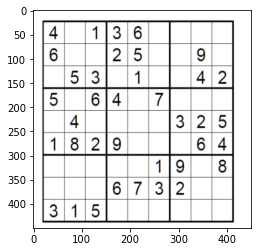

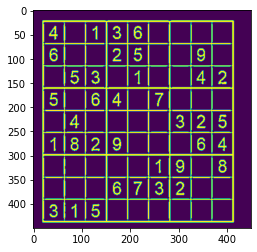

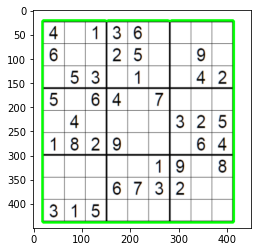

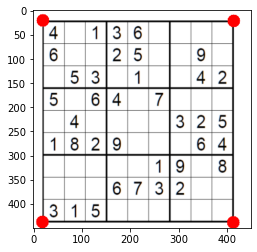

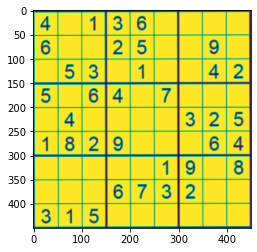

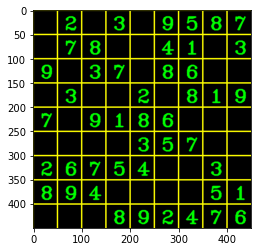

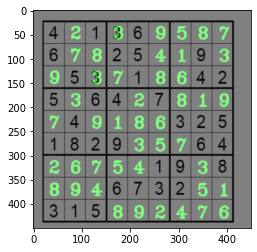

In [58]:
for i in res:
    plt.imshow(i)
    plt.show()

In [39]:
print(grid)

[array([0, 0, 0, 0, 0, 0, 2, 1, 0], dtype=int64), array([6, 0, 0, 2, 0, 0, 0, 0, 3], dtype=int64), array([0, 0, 0, 2, 9, 0, 0, 5, 0], dtype=int64), array([7, 7, 0, 0, 0, 0, 3, 2, 0], dtype=int64), array([4, 0, 0, 0, 2, 0, 9, 0, 8], dtype=int64), array([0, 4, 2, 0, 0, 0, 0, 0, 0], dtype=int64), array([7, 4, 0, 0, 0, 8, 0, 0, 6], dtype=int64), array([4, 0, 0, 0, 0, 7, 8, 0, 2], dtype=int64), array([7, 2, 4, 0, 2, 0, 0, 7, 0], dtype=int64)]


In [ ]:
prin